## Inputs

In [4]:
import os

IN_DIR = '../../data/query-ts/input/'
OUT_DIR = '../../data/query-ts/output/'
IN_GEOJSON = os.path.join(IN_DIR, 'subarea.geojson')
STARTDATE = '2019-04-01' 
ENDDATE = '2019-08-28'
MAX_CLOUD_COVER = 15

## Search and collect imagery

In [5]:
from satsearch import Search

# search for imagery

DATETIME = STARTDATE + '/' + ENDDATE

search = Search.search(bbox=parse_geojson(IN_GEOJSON), datetime=DATETIME, collection='landsat-8-l1', 
                       property=['eo:cloud_cover<'+str(MAX_CLOUD_COVER)]
)
scenes = search.items()

In [6]:
# collect urls
blu_urls, grn_urls, red_urls, nir_urls = [], [], [], []

for i in range(len(scenes)):
    blu_urls.append(scenes[i].assets['B2']['href'])
    grn_urls.append(scenes[i].assets['B3']['href'])
    red_urls.append(scenes[i].assets['B4']['href'])
    nir_urls.append(scenes[i].assets['B5']['href'])

In [7]:
# download subareas for NDVI trend calculations
nir_fp_list = []

for i in range(len(nir_urls)):
    out_path = os.path.join(OUT_DIR, f'nir_{i}.tif')
    nir_fp_list.append(out_path)
    download_subarea(IN_GEOJSON, nir_urls[i], out_path)
    
red_fp_list = []

for i in range(len(red_urls)):
    out_path = os.path.join(OUT_DIR, f'red_{i}.tif')
    red_fp_list.append(out_path)
    download_subarea(IN_GEOJSON, red_urls[i], out_path)

completed nir_0 band
completed nir_1 band
completed nir_2 band
completed nir_3 band
completed nir_4 band
completed nir_5 band
completed nir_6 band
completed nir_7 band
completed nir_8 band
completed nir_9 band
completed nir_10 band
completed red_0 band
completed red_1 band
completed red_2 band
completed red_3 band
completed red_4 band
completed red_5 band
completed red_6 band
completed red_7 band
completed red_8 band
completed red_9 band
completed red_10 band


## Data processing

In [8]:
# read TIF images as arrays

from PIL import Image
import numpy as np

nir_arr_list = [np.array(Image.open(band_path)) for band_path in nir_fp_list]
red_arr_list = [np.array(Image.open(band_path)) for band_path in red_fp_list]

In [9]:
# calculate NDVI

ndvi_list = [calc_ndvi(nir_arr_list[i], red_arr_list[i]) for i in range(len(red_arr_list))]

/home/paperspace/maanas/envs/anaconda3/envs/gdal_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
# clean ndvi

for i in range(len(ndvi_list)):
    ndvi_list[i] = np.where(ndvi_list[i] < 1, ndvi_list[i], 0) # remove outliers, replace with zero

#### To visualize bands from first scene:

In [11]:
# read 4 bands from first scene

bands = 'blu', 'grn', 'red', 'nir'
out_paths = [os.path.join(OUT_DIR,band+'.tif') for band in bands]

download_subarea(IN_GEOJSON, blu_urls[0], out_paths[0])
download_subarea(IN_GEOJSON, grn_urls[0], out_paths[1])
download_subarea(IN_GEOJSON, red_urls[0], out_paths[2])
download_subarea(IN_GEOJSON, nir_urls[0], out_paths[3])
    
band_arr_list = [np.array(Image.open(band_path)) for band_path in out_paths]

completed blu band
completed grn band
completed red band
completed nir band


## Visualize

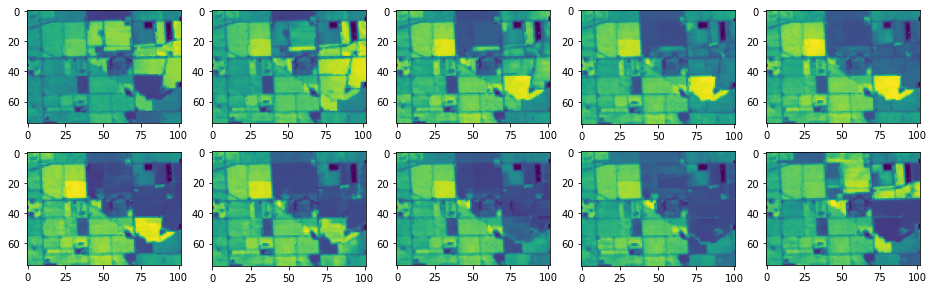

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16,10))

for i in range(10):
    ax = fig.add_subplot(4,5,i+1)
    ax.imshow(ndvi_list[i])

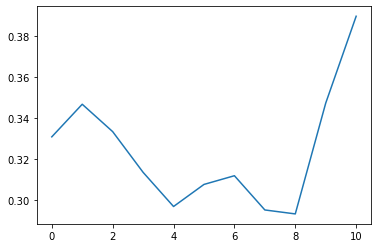

In [21]:
# plot mean NDVI over time
mean_list = [np.mean(ndvi) for ndvi in ndvi_list]
x = np.arange(len(mean_list))
plt.plot(x, mean_list)

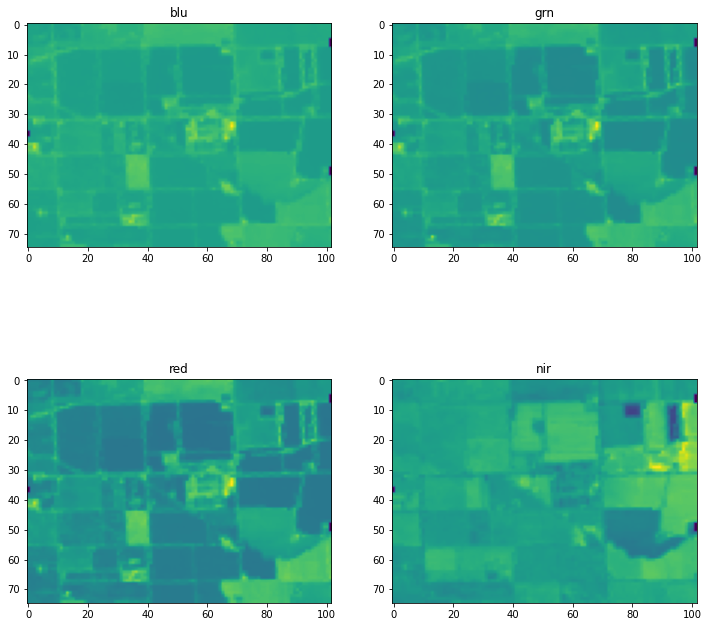

In [20]:
# visualize bands from first scene

fig = plt.figure(figsize=(12,12))
for i in range(0,4):
    ax = fig.add_subplot(2,2,i+1)
    ax.set_title(bands[i])
    ax.imshow(band_arr_list[i])

## Utils

In [1]:
import json

def parse_geojson(geojson):
    X_list, Y_list = [], []
    with open(geojson) as geojson_file:
        geodata = json.load(geojson_file)
        for coords in geodata['features'][0]['geometry']['coordinates'][0]:
            X_list.append(coords[0])
            Y_list.append(coords[1])
    return [min(X_list), min(Y_list), max(X_list), max(Y_list)]

In [2]:
from osgeo import gdal

def download_subarea(geojson, scene_url, out_path):
    scene_url = '/vsicurl/' + scene_url
    gdal.Warp(out_path, scene_url, dstSRS = 'EPSG:4326', cutlineDSName = geojson, cropToCutline = True)
    print('completed ' + os.path.splitext(os.path.basename(out_path))[0])

In [3]:
def calc_ndvi(b1, b2):
    with np.errstate(divide="ignore"):
        n_diff = (b1 - b2) / (b1 + b2)
    if np.isinf(n_diff).any():
        n_diff[np.isinf(n_diff)] = np.nan
    if np.isnan(n_diff).any():
        n_diff = np.ma.masked_invalid(n_diff)
    return n_diff